<a href="https://colab.research.google.com/github/kennenvi/Challange-Dados/blob/main/Regressao_com_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iniciando ambiente
---

## Instalando o PySpark no Google Colab

In [ ]:
!pip install pyspark==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## SparkSession

O ponto de entrada para programar o Spark com a API Dataset e DataFrame.

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Iniciando com Spark") \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

In [ ]:
spark

## Baixando conjunto de dados

In [ ]:
!wget 'https://caelum-online-public.s3.amazonaws.com/challenge-spark/semana-2.zip' && unzip semana-2.zip -d dados/

--2022-12-06 16:54:24--  https://caelum-online-public.s3.amazonaws.com/challenge-spark/semana-2.zip
Resolving caelum-online-public.s3.amazonaws.com (caelum-online-public.s3.amazonaws.com)... 54.231.135.33, 3.5.11.155, 54.231.224.41, ...
Connecting to caelum-online-public.s3.amazonaws.com (caelum-online-public.s3.amazonaws.com)|54.231.135.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2763652 (2.6M) [application/zip]
Saving to: ‘semana-2.zip.1’

semana-2.zip.1      100%[===================>]   2.63M  --.-KB/s    in 0.1s    

2022-12-06 16:54:24 (19.1 MB/s) - ‘semana-2.zip.1’ saved [2763652/2763652]

Archive:  semana-2.zip
replace dados/dataset_transformado_parquet/_SUCCESS? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dados/dataset_transformado_parquet/_SUCCESS  
  inflating: dados/dataset_transformado_parquet/._SUCCESS.crc  
  inflating: dados/dataset_transformado_parquet/part-00000-00341ba7-0a7c-4fef-a81e-1066725a64b1-c000.snappy.parquet  
  infla

# Criando Modelo de Regressão

## Seleção de Features

In [74]:
# Importando módelos
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType, IntegerType

In [ ]:
# Carregando os dados
dados = spark.read.parquet('/content/dados/dataset_transformado_parquet')

In [ ]:
# Visualizando os dados
dados.show()

+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+--------------------+------------+----------+----+-----+------+
|                  id|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|              bairro|        zona|condominio|iptu| tipo| valor|
+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+--------------------+------------+----------+----+-----+------+
|03a386b6-7ab8-4ef...|    0|        43|       43|        1|[Churrasqueira, A...|      2|  null|       Usado| Apartamento|Residencial|   1|            Realengo|  Zona Oeste|       285|null|Venda| 22999|
|1fe78d41-b8e0-4d2...|    0|        44|       44|        1|                  []|      2|     0|       Usado| Apartamento|Residencial|   0|               Irajá|  Zona Norte|       170|   0|Vend

In [ ]:
# Visualizando o Schema
dados.printSchema()

### Convertendo Tipos

Algumas colunas estão com os tipos errados, por isso serão realizadas transformaçãoes (casting) para os tipos corretos:

* "area_total", "area_util", "iptu" e "valor" --> **Double**

* "andar", "banheiros", "quartos", "suites" e "vaga" e "condominio" --> **Integer**

In [ ]:
# Dicionário com a coluna e seu tipo correspondente
dict_casting = {'area_total': DoubleType, 'area_util': DoubleType, 'iptu': DoubleType, 'valor': DoubleType, 
                 'andar': IntegerType, 'banheiros': IntegerType, 'quartos': IntegerType, 'suites': IntegerType, 'vaga': IntegerType, 'condominio': IntegerType}

# Realizando o casting com base no dicionário
dados = dados\
    .select(
        [f.col(col).cast(dict_casting[col]()).alias(col) if col in dict_casting else col for col in dados.columns]
    )

In [ ]:
dados.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_total: double (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: integer (nullable = true)
 |-- iptu: double (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: double (nullable = true)



### Retirando colunas com valores únicos

Algumas colunas possuem valores únicos, pois foram filtradas no processamento anterior. Por isso serão excluídas

In [ ]:
# Verificando se essas colunas realmente possuem apenas um valor
lista_valores_unicos = ['tipo_anuncio', 'tipo_unidade', 'tipo_uso', 'bairro', 'zona', 'tipo']

for i in lista_valores_unicos:
    dados\
        .groupBy(i)\
        .count()\
        .show()

+------------+-----+
|tipo_anuncio|count|
+------------+-----+
|       Usado|66562|
+------------+-----+

+------------+-----+
|tipo_unidade|count|
+------------+-----+
| Apartamento|66562|
+------------+-----+

+-----------+-----+
|   tipo_uso|count|
+-----------+-----+
|Residencial|66562|
+-----------+-----+

+-------------------+-----+
|             bairro|count|
+-------------------+-----+
|             Cocotá|   16|
|       Tomás Coelho|   38|
|              Gávea|  597|
|            Ipanema| 2113|
|           Realengo|   46|
|      Gardênia Azul|    7|
|      Bento Ribeiro|   33|
|              Rocha|   38|
|Vicente de Carvalho|   86|
|         Manguinhos|    1|
|       Campo Grande|  639|
|        Jacarepaguá| 4437|
|               Leme|  234|
|           Botafogo| 3499|
|       Padre Miguel|   15|
|       Santo Cristo|  357|
|           Flamengo| 1378|
|  Engenho da Rainha|   25|
| Pedra de Guaratiba|   12|
|            Piedade|  104|
+-------------------+-----+
only showing to

As colunas "tipo_anuncio", "tipo_unidade", "tipo_uso" e "tipo" serão retiradas, porque possuem apenas uma categoria o que não fornece nenhuma informação para o modelo

In [ ]:
dados = dados.drop('tipo_anuncio', 'tipo_unidade', 'tipo_uso', 'tipo')

A coluna bairro possui muitas classes com poucos valores, o que não agrega informações uteis ao modelo. Por isso será retirada

In [ ]:
dados = dados.drop('bairro')

In [ ]:
# Verificando como a tabela dados está até o momento
dados.show(truncate=False)

+------------------------------------+-----+----------+---------+---------+-----------------------------------------------------------------------------------------------------------------------------------------+-------+------+----+------------+----------+------+--------+
|id                                  |andar|area_total|area_util|banheiros|caracteristicas                                                                                                                          |quartos|suites|vaga|zona        |condominio|iptu  |valor   |
+------------------------------------+-----+----------+---------+---------+-----------------------------------------------------------------------------------------------------------------------------------------+-------+------+----+------------+----------+------+--------+
|03a386b6-7ab8-4eff-891d-f8a16efc1989|0    |43.0      |43.0     |1        |[Churrasqueira, Academia, Playground, Salão de festas, Condomínio fechado, Portão eletrônico, Portaria 

### Tratando valores nulos

As colunas possuem valores nulos que não são bem interpretados pelos modelos, por isso será feito um tratamento neles

In [ ]:
# Transformando os nulos de todas as colunas com numerais em zero
dados = dados\
    .na\
    .fill(0)

In [ ]:
# Transformando listas vazias "[]" em None
dados = dados\
    .withColumn('caracteristicas',
                f.when(f.size('caracteristicas') == 0, None)\
                .otherwise( dados['caracteristicas'] )
                )

In [ ]:
# Removendo amostras onde a zona é uma string vazia ('')
dados = dados\
    .where(dados['zona'] != '')

In [ ]:
dados\
    .groupBy('caracteristicas')\
    .count()\
    .orderBy('caracteristicas')\
    .show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|caracteristicas                                                                                                                                   |count|
+--------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|null                                                                                                                                              |12731|
|[Academia]                                                                                                                                        |57   |
|[Academia, Animais permitidos]                                                                                                                    |2    |
|[Academia, Animais permitidos, Churrasqueira, Elevador, Piscina, Play

### Criando variáveis *dummy*

Os modelos não conseguem ler dados categóricos puros, por isso são utilizadas técnicas para transfomá-los em numeros, sendo um destes a criação de variáveis dummy

As colunas que se enquadram nessa descrição são "caracteristicas" e "zona"

In [ ]:
# Essa coluna possui arrays, por isso foi utilizado o método explode para separar o array em novas amostras
caracteristicas_dummy = dados\
    .select('id', f.explode('caracteristicas').alias('explode_caracteristicas'))\
    .groupBy('id')\
    .pivot('explode_caracteristicas')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [ ]:
zona_dummy = dados\
    .select(
        'id', 'zona'
    )\
    .groupBy('id')\
    .pivot('zona')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [ ]:
# Juntando as variáveis dummy aos dados principais utilizando join
dados = dados\
    .join(caracteristicas_dummy, 'id', how='inner')\
    .join(zona_dummy, 'id', how='inner')

In [ ]:
# Retirando as colunas originais
dataset = dados\
    .drop('caracteristicas')\
    .drop('zona')

In [ ]:
# Conjunto de dados até agora
dataset.show()

+--------------------+-----+----------+---------+---------+-------+------+----+----------+-------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+------------+----------+----------+--------+
|                  id|andar|area_total|area_util|banheiros|quartos|suites|vaga|condominio|   iptu|    valor|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+-----+----------+---------+---------+-------+------+----+----------+-------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+------------+----------+----------+--------+
|fd96bbd5-d631-416...|    0|       0.0|     48.0|        1|      2|     1|   1|         1|    1.0| 315000.0|       1|                

### Salvando dataset processado

O dataset processado será salvo para utilizações futuras

In [ ]:
dataset.write.parquet(
    '/content/dados/dataset_processado_ml',
    'overwrite'
)

### Preparando dados para inserção no modelo

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
# Renomeando "valor" para "label"
dataset = dataset.withColumnRenamed('valor', 'label')

In [ ]:
# Selecionando as colunas que atuarão como features
X = dataset.drop('id', 'label').columns

In [ ]:
X

['andar',
 'area_total',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'Academia',
 'Animais permitidos',
 'Churrasqueira',
 'Condomínio fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria 24h',
 'Portão eletrônico',
 'Salão de festas',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul']

In [ ]:
assembler = VectorAssembler(inputCols=X, outputCol='features')

In [ ]:
# Transformando os dados em vetores
dataset_prep = assembler.transform(dataset).select('features', 'label')

In [75]:
dataset_prep.show()

+--------------------+---------+
|            features|    label|
+--------------------+---------+
|[0.0,0.0,48.0,1.0...| 315000.0|
|[3.0,60.0,60.0,2....| 440000.0|
|[0.0,69.0,69.0,2....| 629000.0|
|[4.0,85.0,85.0,2....|1100000.0|
|[6.0,0.0,328.0,4....| 1.0302E7|
|[8.0,54.0,54.0,2....| 340000.0|
|(23,[2,3,4,5,6,10...| 359000.0|
|[0.0,55.0,55.0,2....| 376000.0|
|[1.0,55.0,55.0,2....| 400100.0|
|[2.0,74.0,74.0,2....| 700000.0|
|[9.0,87.0,87.0,2....| 733700.0|
|[0.0,0.0,80.0,1.0...| 895000.0|
|(23,[0,1,2,3,4,7,...| 950000.0|
|(23,[1,2,3,4,5,6,...|1000000.0|
|[2.0,97.0,97.0,2....|1200000.0|
|[0.0,356.0,356.0,...|2700000.0|
|[5.0,55.0,55.0,2....| 320000.0|
|[6.0,0.0,113.0,3....| 620000.0|
|(23,[1,2,3,4,5,6,...| 740900.0|
|(23,[1,2,3,4,5,6,...| 795000.0|
+--------------------+---------+
only showing top 20 rows



### Verificando correlação entre as variáveis

In [ ]:
from pyspark.ml.stat import Correlation
import pandas as pd

In [ ]:
correlacao = Correlation.corr(dataset_prep, 'features').collect()

In [ ]:
correlacao = correlacao[0][0]

In [ ]:
df_corr = pd.DataFrame(correlacao.toArray(), columns=X, index=X)

In [ ]:
df_corr

,andar,area_total,area_util,banheiros,quartos,suites,vaga,condominio,iptu,Academia,...,Elevador,Piscina,Playground,Portaria 24h,Portão eletrônico,Salão de festas,Zona Central,Zona Norte,Zona Oeste,Zona Sul
andar,1.000000,0.000233,0.020889,0.015930,0.009954,0.017759,0.013261,0.004862,-0.000513,0.047240,...,0.050480,0.021052,0.033553,0.074800,0.068083,0.038230,0.035354,-0.009712,-0.000230,-0.002185
area_total,0.000233,1.000000,-0.002097,0.001330,0.001144,-0.000666,0.000364,-0.000358,-0.000242,0.005776,...,0.004467,0.006181,0.006966,0.007467,0.007831,0.007405,0.002431,-0.000145,0.004768,-0.005932
area_util,0.020889,-0.002097,1.000000,0.686366,0.674062,0.632294,0.491658,0.045239,0.022311,0.006967,...,0.033466,0.028465,-0.014270,-0.025044,0.002254,-0.028293,-0.107634,-0.170873,0.133501,0.028488
banheiros,0.015930,0.001330,0.686366,1.000000,0.667164,0.741722,0.458799,0.026960,0.014011,0.085130,...,0.061639,0.111956,0.069803,-0.056596,-0.033011,0.056768,-0.132955,-0.166267,0.197056,-0.038690
quartos,0.009954,0.001144,0.674062,0.667164,1.000000,0.596462,0.447261,0.022126,0.017929,0.074023,...,0.036810,0.104275,0.096806,-0.028381,-0.019777,0.076783,-0.168396,-0.124420,0.185675,-0.050780
suites,0.017759,-0.000666,0.632294,0.741722,0.596462,1.000000,0.464657,0.028670,0.011209,0.244828,...,0.084341,0.273196,0.179403,0.046470,0.059335,0.160148,-0.110830,-0.213892,0.278102,-0.095412
vaga,0.013261,0.000364,0.491658,0.458799,0.447261,0.464657,1.000000,0.024853,0.011946,0.136633,...,0.023170,0.174891,0.127828,0.004867,0.020121,0.127242,-0.104357,-0.108763,0.247438,-0.152326
condominio,0.004862,-0.000358,0.045239,0.026960,0.022126,0.028670,0.024853,1.000000,0.205853,0.011718,...,0.009650,0.006297,0.005923,0.008875,0.002302,0.005211,-0.004732,-0.010113,0.000279,0.009697
iptu,-0.000513,-0.000242,0.022311,0.014011,0.017929,0.011209,0.011946,0.205853,1.000000,-0.000156,...,0.001213,-0.001890,-0.003613,-0.005602,-0.009092,-0.003528,-0.003941,-0.008811,-0.007506,0.017040
Academia,0.047240,0.005776,0.006967,0.085130,0.074023,0.244828,0.136633,0.011718,-0.000156,1.000000,...,0.270428,0.688896,0.595288,0.381260,0.292719,0.619865,0.039871,-0.136884,0.367612,-0.306140


Criando visualização das correlações para compreensão mais fácil

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

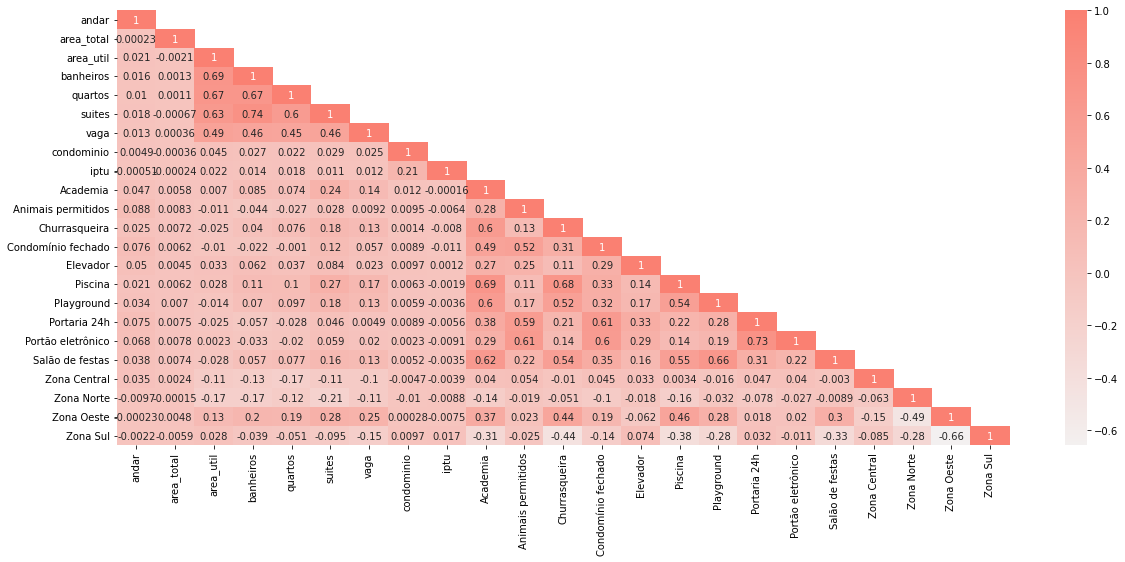

In [76]:
plt.figure(figsize=(20, 8))
paleta = sns.color_palette('light:salmon', as_cmap=True)
mask = np.triu(np.ones_like(df_corr), True)
sns.heatmap(df_corr, annot=True, mask=mask, cmap=paleta)

## Treinando Modelo

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
# Separando em treino e teste
treino, teste = dataset_prep.randomSplit([.7, .3], seed=101)

In [ ]:
# Instanciando modelo
lr = LinearRegression()

In [ ]:
# Treinando o modelo
modelo_lr = lr.fit(treino)

### Extraíndo métricas

As métricas utilizadas foram o R2 e o RMSE

Treino

In [ ]:
# Gerando resumo da performance do modelo para os dados de treino
resumo_modelo = modelo_lr.summary

In [ ]:
resumo_modelo.r2

0.6781339512094222

In [ ]:
resumo_modelo.rootMeanSquaredError

836049.2076567278

Teste

In [ ]:
resumo_teste = modelo_lr.evaluate(teste)

In [ ]:
resumo_teste.r2

0.6663408560991568

In [ ]:
resumo_teste.rootMeanSquaredError

897038.7361500504

In [ ]:
def tabela_metricas(nome_modelo, resumo_treino, resumo_teste):
    print(nome_modelo)
    print("="*30)
    print("Dados de Treino")
    print("="*30)
    print("R²: %f" % resumo_treino.r2)
    print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
    print("")
    print("="*30)
    print("Dados de Teste")
    print("="*30)
    print("R²: %f" % resumo_teste.r2)
    print("RMSE: %f" % resumo_teste.rootMeanSquaredError)

In [ ]:
# Visualizando a performance de ambos
tabela_metricas('Linear Regression', resumo_modelo, resumo_teste)

Linear Regression
Dados de Treino
R²: 0.678134
RMSE: 836049.207657

Dados de Teste
R²: 0.666341
RMSE: 897038.736150
